<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/03_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Network

1. Perceptron
2. Forward propagation - weights, activation, linear and non-linear functions
3. Loss, Cost and Loss Function
4. Backpropagation

### Regression

Loss Function - Mean Squared Error (MSE)

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

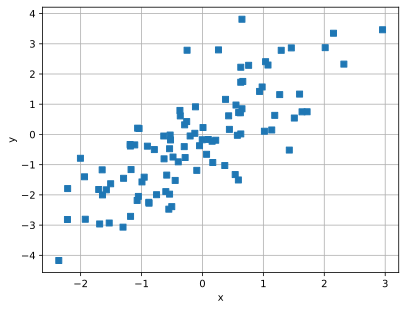

In [ ]:
# create data

N = 100
x = t.randn(N, 1)
y = x + t.randn(N, 1)

# plot the pairs
plt.plot(x, y, 's')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
# build model

ANNreg = nn.Sequential(
    nn.Linear(1, 1, bias=True),  # input layer
    nn.ReLU(),                   # activation function
    nn.Linear(1, 1, bias=True)    # output layer
)

ANNreg

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
# learning rate
learningRate = 0.01

# loss function
lossfun = nn.MSELoss()

# optimizer (the flavour of gradient descent to be implemented)
optimizer = t.optim.SGD(ANNreg.parameters(), lr=learningRate)

In [ ]:
# train the model
numepoch = 1000
losses = t.zeros(numepoch)

for epochi in range(numepoch):

  # forward pass
  y_pred = ANNreg(x)

  # compute loss
  loss = lossfun(y_pred, y)
  losses[epochi] = loss

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

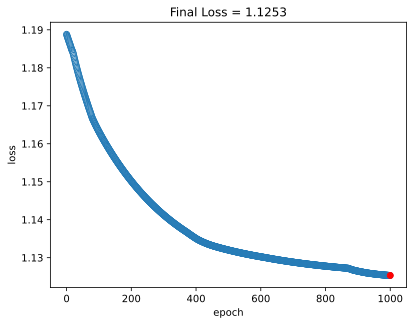

In [ ]:
# show the losses

# manually compute losses
# final forward pass
predictions = ANNreg(x)

# final loss (MSE)
testloss = (predictions - y).pow(2).mean()

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.plot(numepoch, testloss.detach(), 'ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Final Loss = %g'%testloss.item())
plt.show()

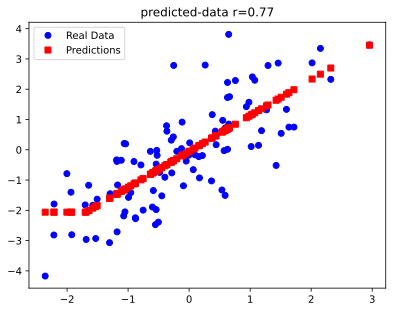

In [ ]:
# plot the data

plt.plot(x,y,'bo',label='Real Data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')
plt.title(f"predicted-data r={np.corrcoef(y.T,predictions.detach().T)[0,1]:.2f}")
plt.legend()
plt.show()

### Manipulate Regression Slopes

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [ ]:
def data(N,m):
  x = t.randn(N, 1)
  y = m*x + t.randn(N, 1) * 1.5
  return x, y

In [ ]:
def model(x,y,learning_rate,momentum,numepoch):

  # build model
  ANNreg = nn.Sequential(
      nn.Linear(1, 1, bias=True),  # input layer
      nn.ReLU(),                   # activation function
      nn.Linear(1, 1, bias=True)    # output layer
  )

  # loss function
  lossfun = nn.MSELoss()

  # learning rate and momentum
  lr = learning_rate
  mtm = momentum

  # optimizer (the flavour of gradient descent to be implemented)
  optimizer = t.optim.SGD(ANNreg.parameters(), lr=lr)

  # number of epochs
  nepoch = numepoch
  losses = t.zeros(nepoch)

  for i in range(nepoch):
    y_pred = ANNreg(x)
    loss = lossfun(y_pred, y)
    losses[i] = loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = ANNreg(x)

  return predictions, losses


In [ ]:
slopes = t.linspace(-2,2,21)
numExps = 50
results = np.zeros((len(slopes),numExps,2))

for i,m in enumerate(slopes):
  for j in range(numExps):
    x, y = data(50,slopes[i])
    yHat, losses = model(x,y,0.01,0.9,1000)

    # store the final loss and performance
    results[i,j,0] = losses[-1]
    results[i,j,1] = np.corrcoef(y.T,yHat.detach().T)[0,1]

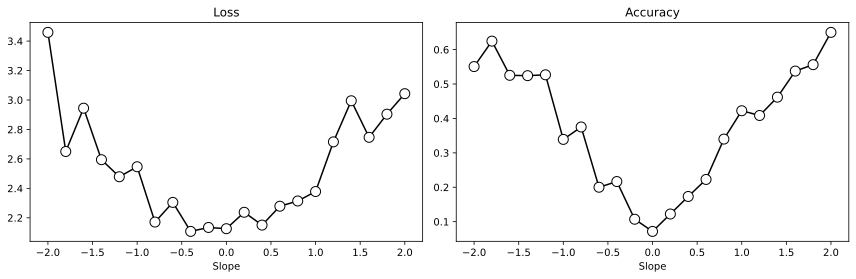

In [ ]:
# correlation can be 0 if the model didn't do well. Set nan's -> 0
results[np.isnan(results)] = 0

# plot loss and accuracy as a function of slope

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(slopes,np.mean(results[:,:,0],axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax[0].set_xlabel('Slope')
ax[0].set_title('Loss')

ax[1].plot(slopes,np.mean(results[:,:,1],axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax[1].set_xlabel('Slope')
ax[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

1. Why were losses larger with larger slopes, even though the fit to the data was better?
- Losses are not normalized, they are in the scale of data. Larger slopes led to more variance in y.

- **Note :** The losses could only be compared across same data, or in different dataset that are normalized to the same numeric range.

2. Why did the model accuracy dropped to 0 when the slope was close to 0?
- x is less informative about y when the slope descreases. The model had less useful information about y.

- **Note :** ANNs (and DL in general) don't predict data values; they learn relationships across variables and provide the distribution of y for a given x from which y_pred is chosen as the one y which holds highest probability of occurence.

### Classification

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

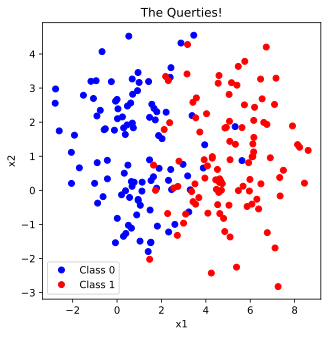

In [ ]:
# catagorical dummy data

nPerClust = 100
blur = 1.5

A = [1,1]
B = [5,1]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [ ]:
# build the model
ANNclassify = nn.Sequential(
    nn.Linear(2, 1, bias=True),  # imput layer
    nn.ReLU(),                   # activation layer
    nn.Linear(1, 1, bias=True),  # output layer
    nn.Sigmoid(),                # final activation unit
)

ANNclassify

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
# loss function
lossfun = nn.BCELoss()
# For future reference please note that it is better to use BCEWithLogitsLoss

# learning rate
lr = 0.1

# optimizer
optimizer = t.optim.SGD(ANNclassify.parameters(), lr=lr)

In [ ]:
# number of epochs
numepochs = 1000
losses = t.zeros(numepochs)

for i in range(numepochs):

  # forward pass
  y_pred = ANNclassify(data)

  # calculate loss and store value
  loss = lossfun(y_pred,labels)
  losses[i] = loss

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

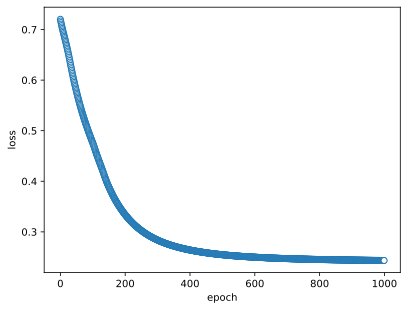

In [ ]:
# show the losses

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# final forward pass
predictions = ANNclassify(data)

predlabels = predictions > 0.5

# find errors
misclassified = np.where(predlabels.detach().T != labels.T)[1]
# misclassified

# total accuracy
totalacc = 100 - 100*len(misclassified)/len(labels)

print(f'Total Accuracy = {totalacc}%')

Total Accuracy = 90.5%


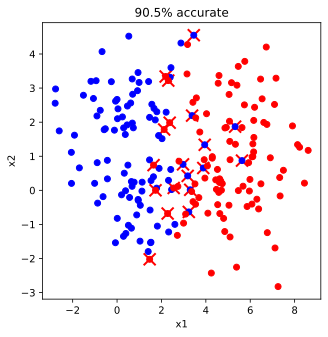

In [ ]:
# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
# plt.legend()
plt.show()

### Learning Rate Comparison

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

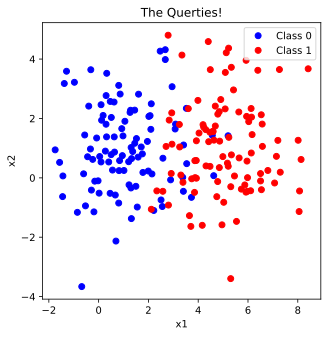

In [ ]:
# catagorical dummy data

nPerClust = 100
blur = 1.5

A = [1,1]
B = [5,1]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[t.where(labels==0)[0],0], data[t.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[t.where(labels==1)[0],0], data[t.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [ ]:
def BuildANNclassify(learning_rate):
  # build the model
  ANNclassify = nn.Sequential(
      nn.Linear(2, 1, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(1, 1, bias=True),  # output layer
      # nn.Sigmoid(),                # final activation unit
  )

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # learning rate (function variable here)
  lrate = learning_rate

  # optimizer
  optimizer = t.optim.SGD(ANNclassify.parameters(), lr=lrate)

  return ANNclassify, lossfun, optimizer

In [ ]:
def train_model():
  # number of epochs
  numepochs = 1000
  losses = t.zeros(numepochs)

  for i in range(numepochs):

    # forward pass
    y_pred = ANNclassify(data)

    # calculate loss and store value
    loss = lossfun(y_pred,labels)
    losses[i] = loss

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final predictions
  predictions = ANNclassify(data)

  # accuracy
  totalacc = 100*t.mean(((predictions > 0) == labels).float())
  # Shouldn't this be predictions > 0.5? Because we have omitted sigmoid layer and used BCEwithLogitsLoss

  return losses, predictions, totalacc

predictions samples: 
tensor([-3.4298, -2.9378, -5.1130, -0.6103, -4.2920, -0.9788, -2.1799, -4.9453,
        -7.8093], grad_fn=<PermuteBackward0>)
total accuracy: 89.5


/tmp/ipython-input-1007335292.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  print(f"predictions samples: \n{predictions[t.where((predictions > 0)==labels)[0],0][0:9].T}")


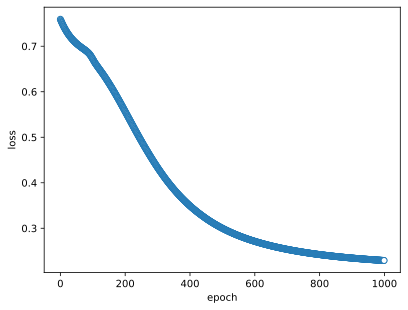

In [ ]:
# let's test the code

ANNclassify, lossfun, optimizer = BuildANNclassify(0.05)
losses, predictions, totalacc = train_model()
print(f"predictions samples: \n{predictions[t.where((predictions > 0)==labels)[0],0][0:9].T}")
print(f"total accuracy: {totalacc}")

# show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

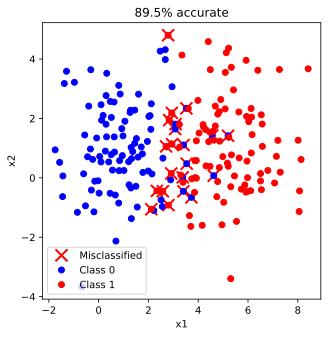

In [ ]:
# view the check data

# t.where((predictions > 0).float().T != labels.T)

# find errors
misclassified = t.where(((predictions > 0)).detach().T != labels.T)[1]
# misclassified
# data[misclassified,0]

# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [ ]:
# Let's run the experiment

learning_rates = t.linspace(0.001, 0.1, 50)
numepochs = 1000

accByLR = t.zeros(len(learning_rates))
allLosses = t.zeros((len(learning_rates),numepochs))

for i,lr in enumerate(learning_rates):
  ANNclassify, lossfun, optimizer = BuildANNclassify(lr)
  losses, predictions, totalacc = train_model()
  accByLR[i] = totalacc
  allLosses[i,:] = losses.detach()

In [ ]:
# accByLR
# allLosses

tensor(0.8600)

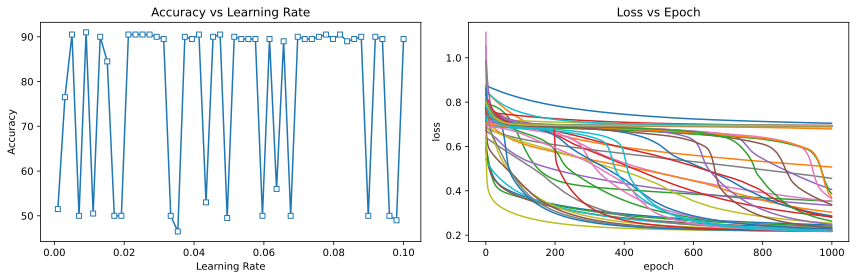

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(learning_rates,accByLR,'s-',markerfacecolor='w',markersize=5)
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs Learning Rate')

ax[1].plot(allLosses.T)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].set_title('Loss vs Epoch')

plt.tight_layout()
plt.show()

Sometimes the model got lucky with an initial weight randomization. This means chance played a role in our conclusions.

Let's run each iteration 50 times and take average of the results.

In [ ]:
# let's run each iteration of learning rate over 50 rounds and take average of accuracy

learning_rates = t.linspace(0.001, 0.1, 50)
NumExps = 50

avgAccByLR = t.zeros(len(learning_rates))
avgAllLosses = t.zeros((len(learning_rates),numepochs))

for i,lr in enumerate(learning_rates):
  AccByLR = t.zeros(NumExps)
  AllLosses = t.zeros((NumExps,numepochs))
  for j in range(NumExps):
    ANNclassify, lossfun, optimizer = BuildANNclassify(lr)
    losses, predictions, totalacc = train_model()
    AccByLR[j] = totalacc
    AllLosses[j,:] = losses.detach()

  avgAccByLR[i] += AccByLR.mean()
  avgAllLosses[i,:] += AllLosses.mean(axis=0)


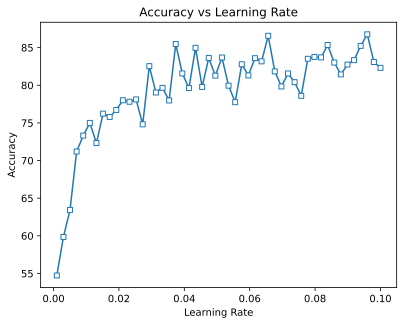

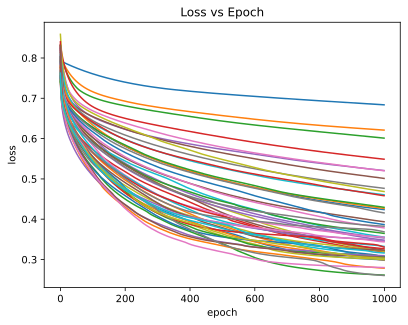

In [ ]:
plt.plot(learning_rates,avgAccByLR,'s-',markerfacecolor='w',markersize=5)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

plt.plot(avgAllLosses.T)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.show()

### Multilayer ANN Primer

Let's carry out the same experiment with more layers and neuron units

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

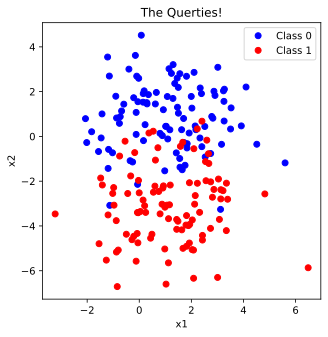

In [ ]:
# catagorical dummy data

nPerClust = 100
blur = 1.5

A = [1,1]
B = [1,-3]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[t.where(labels==0)[0],0], data[t.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[t.where(labels==1)[0],0], data[t.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [ ]:
def BuildANNclassify(learning_rate):
  # build the model
  ANNclassify = nn.Sequential(
      nn.Linear(2, 16, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(16, 4, bias=True),  # output layer
      nn.ReLU(),                   # activation layer
      nn.Linear(4, 1, bias=True),  # output layer
      nn.Sigmoid(),                # final activation unit
  )

  # loss function
  lossfun = nn.BCELoss()

  # learning rate (function variable here)
  lrate = learning_rate

  # optimizer
  optimizer = t.optim.SGD(ANNclassify.parameters(), lr=lrate)

  return ANNclassify, lossfun, optimizer

In [ ]:
def train_model():
  # number of epochs
  numepochs = 1000
  losses = t.zeros(numepochs)

  for i in range(numepochs):

    # forward pass
    y_pred = ANNclassify(data)

    # calculate loss and store value
    loss = lossfun(y_pred,labels)
    losses[i] = loss

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final predictions
  predictions = ANNclassify(data)

  # accuracy
  totalacc = 100*t.mean(((predictions > 0.5) == labels).float())
  # Shouldn't this be predictions > 0 now? Because we have kept sigmoid layer now and used BCELoss

  return losses, predictions, totalacc

predictions samples: 
tensor([0.0357, 0.1145, 0.0594, 0.0073, 0.1382, 0.0129, 0.0007, 0.0014, 0.0024],
       grad_fn=<PermuteBackward0>)
total accuracy: 88.0


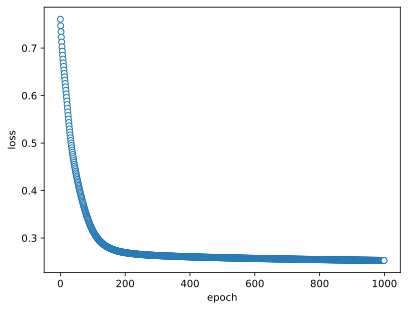

In [ ]:
# let's test the code

ANNclassify, lossfun, optimizer = BuildANNclassify(0.05)
losses, predictions, totalacc = train_model()
print(f"predictions samples: \n{predictions[t.where((predictions > 0.5)==labels)[0],0][0:9].T}")
print(f"total accuracy: {totalacc}")

# show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

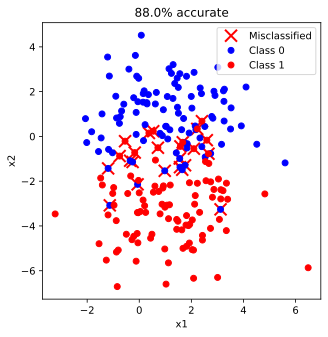

In [ ]:
# view the check data

# t.where((predictions > 0).float().T != labels.T)

# find errors
misclassified = t.where(((predictions > 0.5)).detach().T != labels.T)[1]
# misclassified
# data[misclassified,0]

# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [ ]:
# let's run each iteration of learning rate over 50 rounds and take average of accuracy

learning_rates = t.linspace(0.001, 0.1, 50)
NumExps = 5

avgAccByLR = t.zeros(len(learning_rates))
avgAllLosses = t.zeros((len(learning_rates),numepochs))

for i,lr in enumerate(learning_rates):
  AccByLR = t.zeros(NumExps)
  AllLosses = t.zeros((NumExps,numepochs))
  for j in range(NumExps):
    ANNclassify, lossfun, optimizer = BuildANNclassify(lr)
    losses, predictions, totalacc = train_model()
    AccByLR[j] = totalacc
    AllLosses[j,:] = losses.detach()

  avgAccByLR[i] += AccByLR.mean()
  avgAllLosses[i,:] += AllLosses.mean(axis=0)


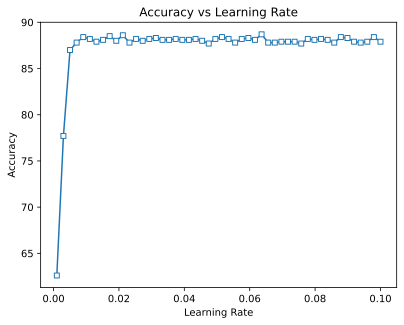

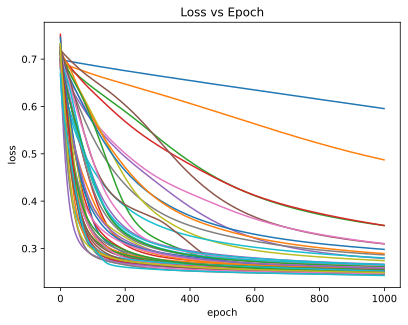

In [ ]:
plt.plot(learning_rates,avgAccByLR,'s-',markerfacecolor='w',markersize=5)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

plt.plot(avgAllLosses.T)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.show()

**Please Note:**

Simple Problems require Simple Solutions.

Querties are linearly separable. so a linear separator will out-perform a non-linear separator.

Hence, you would see that logistic regression or k-means would outperform non-linear models since complex models have a natural tendencies to find complex boundaries/solutions.

**Always look at the problem first and don't blindly throw a complex model into play**

### Multi-Output ANN (iris dataset)

In [1]:
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


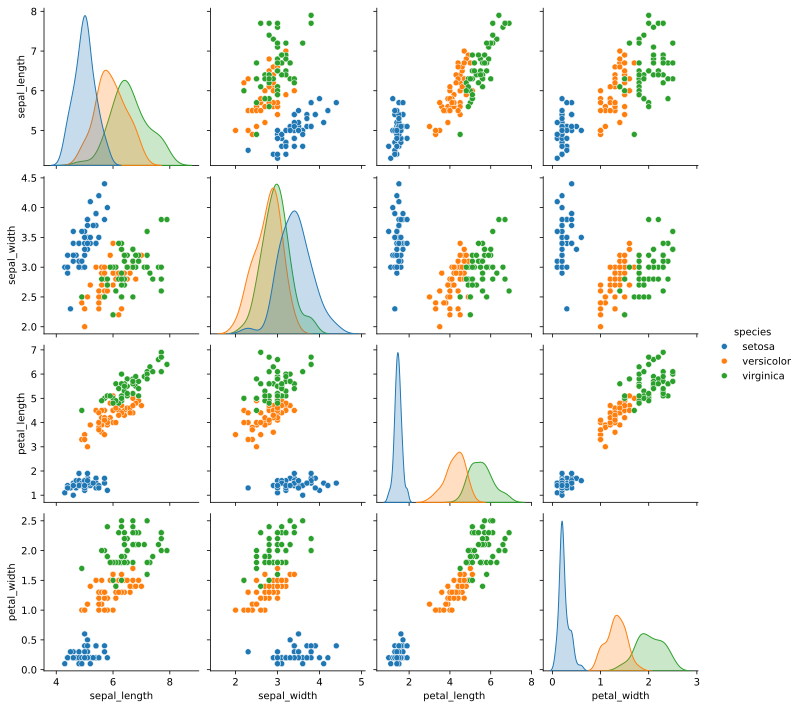

In [3]:
# some plots to show the data
sns.pairplot(iris, hue='species')
plt.show()

In [4]:
# organize the data

data = t.tensor(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values).float()
labels = t.zeros(len(data), dtype=t.long)
labels[iris.species == 'setosa'] = 0
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

print(f"data: \n{data[0:9]}")
print(f"labels: \n{labels[0:9]}")


data: 
tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [4.6000, 3.1000, 1.5000, 0.2000],
        [5.0000, 3.6000, 1.4000, 0.2000],
        [5.4000, 3.9000, 1.7000, 0.4000],
        [4.6000, 3.4000, 1.4000, 0.3000],
        [5.0000, 3.4000, 1.5000, 0.2000],
        [4.4000, 2.9000, 1.4000, 0.2000]])
labels: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])


In [5]:
# create the model

def BuiltMultiANN():
  ANNmulti = nn.Sequential(
      nn.Linear(4, 64, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(64, 64, bias=True),  # hidden layer
      nn.ReLU(),                   # activation layer
      nn.Linear(64, 3, bias=True),  # output layer
  )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = t.optim.SGD(ANNmulti.parameters(), lr=0.05)

  return ANNmulti, lossfun, optimizer

In [11]:
def train_model():

  # number of epochs
  numepochs = 1000

  # initialize losses
  losses = t.zeros(numepochs)
  ongoingAcc = t.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmulti(data)

    # compute loss
    loss = lossfun(yHat,labels)
    losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute accuracy
    matches = t.argmax(yHat,axis=1) == labels     # booleans (false/true)
    matchesNumeric = matches.float()              # convert to numbers (0/1)
    accuracyPct = 100*t.mean(matchesNumeric)      # average and x100
    ongoingAcc[epochi] = accuracyPct              # add to list of accuracies

  # final forward pass
  predictions = ANNmulti(data)

  predlabels = t.argmax(predictions,axis=1)
  totalacc = 100*t.mean((predlabels == labels).float())

  return losses, ongoingAcc, totalacc, predictions

Final accuracy: 98%


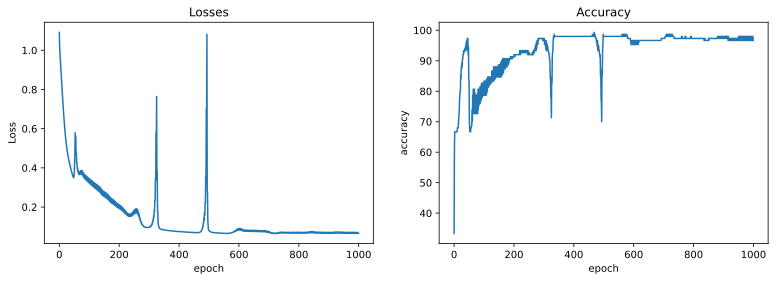

In [13]:
ANNmulti, lossfun, optimizer = BuiltMultiANN()
losses, ongoingAcc, totalacc, predictions = train_model()

# report accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent

In [14]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
t.sum(sm(predictions),axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

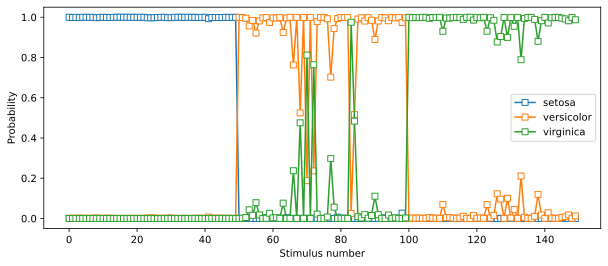

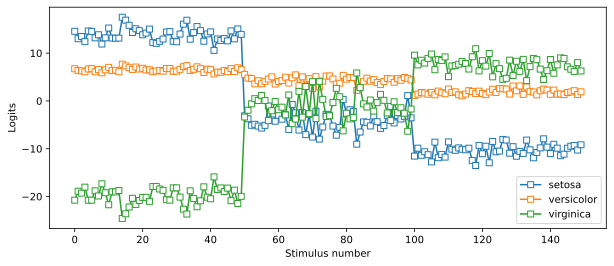

In [17]:
# plot the raw model outputs

fig = plt.figure(figsize=(10,4))

plt.plot(sm(predictions.detach()),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

# try it again without the softmax!

fig = plt.figure(figsize=(10,4))

plt.plot(predictions.detach(),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Logits')
plt.legend(['setosa','versicolor','virginica'])
plt.show()


### More Qwerties : Multi-dimentional

In [18]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

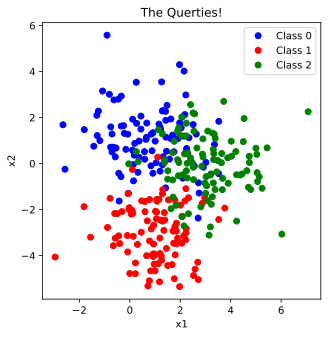

In [28]:
# catagorical dummy data

nPerClust = 100
blur = 1.25

A = [1,1]
B = [1,-3]
C = [3, 0]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1)), np.ones((nPerClust,1))*2))
# print(labels_np.T)

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to PyTorch
global data, labels
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).long().squeeze() # Correct labels to be 1D LongTensor

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[t.where(labels==0)[0],0], data[t.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[t.where(labels==1)[0],0], data[t.where(labels==1)[0],1], 'ro', label='Class 1')
plt.plot(data[t.where(labels==2)[0],0], data[t.where(labels==2)[0],1], 'go', label='Class 2')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [30]:
# create the model

def BuiltMultiANN():
  ANNmulti = nn.Sequential(
      nn.Linear(2, 4, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(4, 4, bias=True),  # hidden layer
      nn.ReLU(),                   # activation layer
      nn.Linear(4, 3, bias=True),  # output layer
  )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = t.optim.SGD(ANNmulti.parameters(), lr=0.05)

  return ANNmulti, lossfun, optimizer

In [31]:
def train_model():
  # number of epochs
  numepochs = 1000
  losses = t.zeros(numepochs)
  ongoingAcc = t.zeros(numepochs)

  for i in range(numepochs):

    # forward pass
    y_pred = ANNmulti(data)

    # calculate loss and store value
    loss = lossfun(y_pred,labels)
    losses[i] = loss

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ongoingAcc[i] = 100*t.mean((t.argmax(y_pred,axis=1) == labels).float())

  # final predictions
  predictions = ANNmulti(data)
  # final accuracy
  totalacc = 100*t.mean((t.argmax(predictions, axis=1) == labels).float())

  return losses, ongoingAcc, totalacc, predictions

Final accuracy: 81.6667%


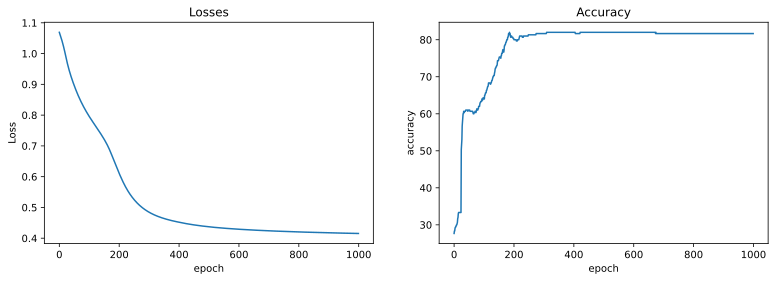

In [32]:
ANNmulti, lossfun, optimizer = BuiltMultiANN()
losses, ongoingAcc, totalacc, predictions = train_model()

# report accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent

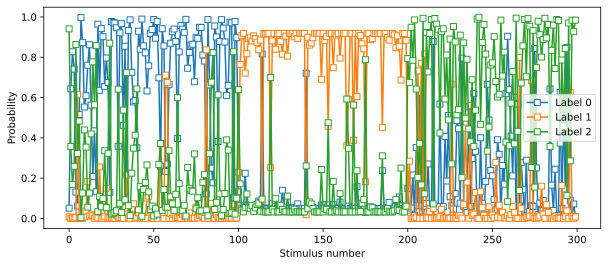

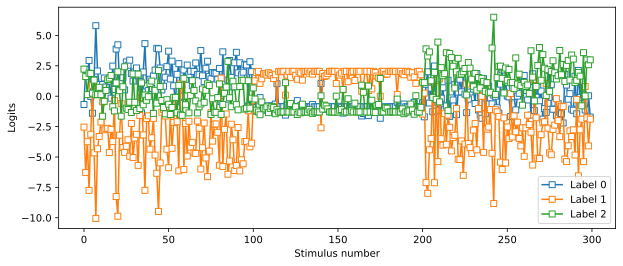

In [35]:
# softmax function
sm = nn.Softmax(1)

# plot the raw model outputs

fig = plt.figure(figsize=(10,4))

plt.plot(sm(predictions.detach()),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['Label 0','Label 1','Label 2'])
plt.show()

# try it again without the softmax!

fig = plt.figure(figsize=(10,4))

plt.plot(predictions.detach(),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Logits')
plt.legend(['Label 0','Label 1','Label 2'])
plt.show()


misclassified: 
tensor([  0,   4,   5,  14,  15,  16,  24,  29,  32,  34,  40,  54,  57,  58,
         64,  81,  84,  85,  88,  97, 100, 114, 119, 140, 153, 164, 168, 175,
        206, 207, 208, 210, 215, 219, 224, 226, 232, 236, 237, 239, 247, 248,
        258, 259, 260, 263, 265, 266, 273, 275, 284, 290, 292, 294, 296])


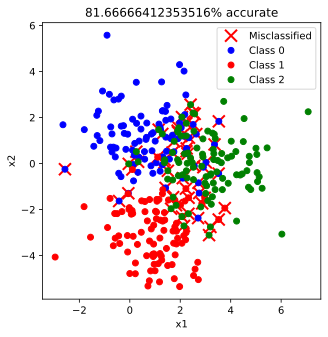

In [39]:
# view the check data

# t.where((predictions > 0).float().T != labels.T)

# find errors
misclassified = t.where((t.argmax(predictions, axis=1) != labels))[0]
print(f"misclassified: \n{misclassified}")

# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[t.where(labels==0)[0],0], data[t.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[t.where(labels==1)[0],0], data[t.where(labels==1)[0],1], 'ro', label='Class 1')
plt.plot(data[t.where(labels==2)[0],0], data[t.where(labels==2)[0],1], 'go', label='Class 2')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

### Comparing the number of hidden units (iris dataset)

In [40]:
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [41]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# iris.head()

In [42]:
# some plots to show the data
# sns.pairplot(iris, hue='species')
# plt.show()

In [43]:
# organize the data

data = t.tensor(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values).float()
labels = t.zeros(len(data), dtype=t.long)
labels[iris.species == 'setosa'] = 0
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

# print(f"data: \n{data[0:9]}")
# print(f"labels: \n{labels[0:9]}")


In [44]:
# create the model

def BuiltMultiANN(hidden_layer_units:int):
  ANNmulti = nn.Sequential(
      nn.Linear(4, hidden_layer_units, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(hidden_layer_units, hidden_layer_units, bias=True),  # hidden layer
      nn.ReLU(),                   # activation layer
      nn.Linear(hidden_layer_units, 3, bias=True),  # output layer
  )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = t.optim.SGD(ANNmulti.parameters(), lr=0.05)

  return ANNmulti, lossfun, optimizer

In [53]:
def train_model():

  # number of epochs
  numepochs = 150

  # # initialize losses
  # losses = t.zeros(numepochs)
  # ongoingAcc = t.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ANNmulti(data)

    # compute loss
    loss = lossfun(yHat,labels)
    # losses[epochi] = loss

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # # compute accuracy
    # ongoingAcc[epochi] = 100*t.mean((t.argmax(yHat,axis=1) == labels).float())              # add to list of accuracies

  # final forward pass and loss
  predictions = ANNmulti(data)
  finalloss = lossfun(predictions,labels)

  # final accuracy
  totalacc = 100*t.mean((t.argmax(predictions,axis=1) == labels).float())

  return totalacc, finalloss

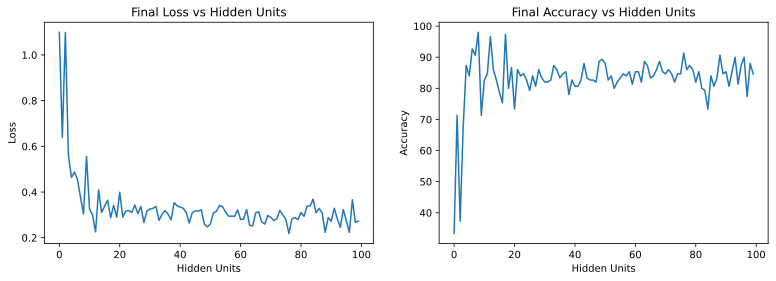

In [54]:
numHiddens = np.arange(1,101)
allAccuracy = t.zeros(len(numHiddens))
allFinalLosses = t.zeros(len(numHiddens))

for nunits in numHiddens:
  ANNmulti, lossfun, optimizer = BuiltMultiANN(nunits)
  totalacc, finalloss = train_model()
  allAccuracy[nunits-1] = totalacc
  allFinalLosses[nunits-1] = finalloss

# report accuracy
fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(allFinalLosses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Hidden Units')
ax[0].set_title('Final Loss vs Hidden Units')

ax[1].plot(allAccuracy.detach())
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Hidden Units')
ax[1].set_title('Final Accuracy vs Hidden Units')
plt.show()
# run training again to see whether this performance is consistent

### Depth vs Breadth: Number of Parameters

1. Definition of Breadth and Depth
2. Difference in properties and count of parameters
3. Performance difference

In [55]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

In [58]:
# build two models

widenet = nn.Sequential(
    nn.Linear(2,4),  # hidden layer
    nn.Linear(4,3),  # output layer
    )


deepnet = nn.Sequential(
    nn.Linear(2,2),  # hidden layer
    nn.Linear(2,2),  # hidden layer
    nn.Linear(2,3),  # output layer
    )

# print them out to have a look
print(f"widenet: \n",widenet)
print(' ')
print(f"deepnet: \n",deepnet)

widenet: 
 Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=3, bias=True)
)
 
deepnet: 
 Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=3, bias=True)
)


In [61]:
# let's hit inside the models

# check out the parameters

print("DEEPNET PARAMETERS:\n")
for p in deepnet.named_parameters():
  print(p)
  print(' ')

print("WIDENET PARAMETERS:\n")
for p in widenet.named_parameters():
  print(p)
  print(' ')

DEEPNET PARAMETERS:

('0.weight', Parameter containing:
tensor([[ 0.6649, -0.0206],
        [ 0.5243, -0.3293]], requires_grad=True))
 
('0.bias', Parameter containing:
tensor([-0.1856, -0.3943], requires_grad=True))
 
('1.weight', Parameter containing:
tensor([[-0.4384,  0.4350],
        [-0.3736,  0.0952]], requires_grad=True))
 
('1.bias', Parameter containing:
tensor([-0.0921, -0.3834], requires_grad=True))
 
('2.weight', Parameter containing:
tensor([[ 0.5635,  0.4815],
        [-0.0430,  0.1171],
        [-0.2353,  0.3060]], requires_grad=True))
 
('2.bias', Parameter containing:
tensor([-0.5980,  0.0032, -0.3342], requires_grad=True))
 
WIDENET PARAMETERS:

('0.weight', Parameter containing:
tensor([[-0.6913,  0.3516],
        [-0.2486,  0.6015],
        [-0.2642, -0.0075],
        [ 0.1757, -0.3409]], requires_grad=True))
 
('0.bias', Parameter containing:
tensor([-0.2578, -0.4139, -0.0355, -0.5508], requires_grad=True))
 
('1.weight', Parameter containing:
tensor([[-0.2576,  0

In [67]:
# count the number of nodes ( = the number of biases)

# named_parameters() is an iterable that returns the tuple (name,numbers)
numNodesInWide = 0
for paramName,paramVect in widenet.named_parameters():
  if 'bias' in paramName:
    numNodesInWide += len(paramVect)

numNodesInDeep = 0
for paramName,paramVect in deepnet.named_parameters():
  if 'bias' in paramName:
    numNodesInDeep += len(paramVect)


print('There are %s nodes in the wide network.' %numNodesInWide)
print('There are %s nodes in the deep network.' %numNodesInDeep)

There are 7 nodes in the wide network.
There are 7 nodes in the deep network.


In [68]:
print("DEEPNET PARAMETERS:\n")
for p in deepnet.parameters():
  print(p)
  print(' ')

print("WIDENET PARAMETERS:\n")
for p in widenet.parameters():
  print(p)
  print(' ')

DEEPNET PARAMETERS:

Parameter containing:
tensor([[ 0.6649, -0.0206],
        [ 0.5243, -0.3293]], requires_grad=True)
 
Parameter containing:
tensor([-0.1856, -0.3943], requires_grad=True)
 
Parameter containing:
tensor([[-0.4384,  0.4350],
        [-0.3736,  0.0952]], requires_grad=True)
 
Parameter containing:
tensor([-0.0921, -0.3834], requires_grad=True)
 
Parameter containing:
tensor([[ 0.5635,  0.4815],
        [-0.0430,  0.1171],
        [-0.2353,  0.3060]], requires_grad=True)
 
Parameter containing:
tensor([-0.5980,  0.0032, -0.3342], requires_grad=True)
 
WIDENET PARAMETERS:

Parameter containing:
tensor([[-0.6913,  0.3516],
        [-0.2486,  0.6015],
        [-0.2642, -0.0075],
        [ 0.1757, -0.3409]], requires_grad=True)
 
Parameter containing:
tensor([-0.2578, -0.4139, -0.0355, -0.5508], requires_grad=True)
 
Parameter containing:
tensor([[-0.2576,  0.1404,  0.3804, -0.0811],
        [ 0.4227, -0.2835,  0.1737, -0.0367],
        [-0.2854, -0.2864, -0.3283,  0.4873]]

In [69]:
nparams = np.sum([ p.numel() for p in widenet.parameters() if p.requires_grad ])
print('Widenet has %s parameters'%nparams)

nparams = np.sum([ p.numel() for p in deepnet.parameters() if p.requires_grad ])
print('Deepnet has %s parameters'%nparams)

Widenet has 27 parameters
Deepnet has 21 parameters


In [73]:
# A nice simple way to print out the model info.
from torchsummary import summary

# Ensure the model and input are on the same device.
# By default, models created with nn.Sequential are on the CPU unless explicitly moved.
# The `torchsummary.summary` function defaults to `device="cuda"`.
# We need to specify `device="cpu"` to match the model's device.
summary(widenet,(1,2), device="cpu")


### NOTE ABOUT THE CODE IN THIS CELL:
# torchsummary is being replaced by torchinfo.
# If you are importing these libraries on your own (via pip), then see the following website:
#        https://pypi.org/project/torch-summary/
# However, torchsummary will continue to be supported, so if the code in this cell works (meaning torchsummary is already installed),
# then you don't need to do anything!

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              12
            Linear-2                 [-1, 1, 3]              15
Total params: 27
Trainable params: 27
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Defining models using nn.Sequential vs class

1. Class provides more flexibility compared to nn.Sequential
2. Class allows for all of Python skills to be applied

In [74]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

# NEW!
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### define the class

class theClass4ANN(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(2,1)

    ### output layer
    self.output = nn.Linear(1,1)

  # forward pass
  def forward(self,x):

    # pass through the input layer
    x = self.input(x)

    # apply relu
    x = F.relu( x )

    # output layer
    x = self.output(x)
    x = torch.sigmoid(x)

    return x


### create an instance of the class
ANNclassify = theClass4ANN()

### Depth vs Breadth Experiment

In [75]:
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [76]:
import seaborn as sns
iris = sns.load_dataset('iris')

# organize the data
data = t.tensor(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values).float()
labels = t.zeros(len(data), dtype=t.long)
labels[iris.species == 'setosa'] = 0
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

In [83]:
# create a class for the model

class ANNiris(nn.Module):
  def __init__(self, nUnits, nLayers):
    super().__init__() # Call superclass constructor first
    # create a dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers

    # input layer
    self.layers['input'] = nn.Linear(4, nUnits)

    # hidden layers
    for i in range(nLayers):
      self.layers[f"hidden{i}"] = nn.Linear(nUnits,nUnits) # Fix typo: nnLinear -> nn.Linear

    # output layer
    self.layers['output'] = nn.Linear(nUnits,3)

  # forward pass
  def forward(self,x):

    # input layer
    x = self.layers['input'](x)

    # hidden layers
    for i in range(self.nLayers):
      x = F.relu(self.layers[f"hidden{i}"](x))

    # output layer
    x = self.layers['output'](x)

    return x

In [84]:
# generate an instance of the model and inspect it
nUnitsPerLayer = 12
nLayers = 4
net = ANNiris(nUnitsPerLayer, nLayers)
print(f"net: \n{net}")

net: 
ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)


In [86]:
# a quick test of running some numbers through the model
# Thsi ensures that the architecture is internally consistent

# 10 samples, 4 definitions
tmpx = t.randn(10,4)
tmpout = net(tmpx)

print(f"tmpout shape: {tmpout.shape}")
print(f"tmpout: \n{tmpout}")

# shape is correct

tmpout shape: torch.Size([10, 3])
tmpout: 
tensor([[-0.0974, -0.2652,  0.2243],
        [-0.1060, -0.2699,  0.2232],
        [-0.0987, -0.2652,  0.2178],
        [-0.0986, -0.2651,  0.2184],
        [-0.0972, -0.2637,  0.2259],
        [-0.0989, -0.2653,  0.2178],
        [-0.1025, -0.2687,  0.2233],
        [-0.0981, -0.2653,  0.2210],
        [-0.0980, -0.2646,  0.2217],
        [-0.0978, -0.2665,  0.2223]], grad_fn=<AddmmBackward0>)


In [87]:
# a function to train the model

def trainTheModel(theModel):

  # define the loss function and optimizer
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(theModel.parameters(),lr=.01)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = theModel(data)

    # compute loss
    loss = lossfun(yHat,labels)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  # final forward pass to get accuracy
  predictions = theModel(data)
  predlabels = torch.argmax(predictions,axis=1)
  acc = 100*torch.mean((predlabels == labels).float())

  # total number of trainable parameters in the model
  nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)

  # function outputs
  return acc,nParams

In [88]:
# test the function once

numepochs = 2500
acc = trainTheModel(net)

# check the outputs
acc # tuple containing (accuracy,nparams)

(tensor(98.6667), 723)

In [90]:
# the main experiment

# define the mdoel parameters
numlayers = range(1,6)
numunits = range(4,101,3)

# initialize output matrices
accuracies  = np.zeros((len(numunits),len(numlayers)))
totalparams = np.zeros((len(numunits),len(numlayers)))

# number of training epochs
numepochs = 500


# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create a fresh model instance
    net = ANNiris(numunits[unitidx],numlayers[layeridx])

    # run the model and store the results
    acc,nParams = trainTheModel(net)
    accuracies[unitidx,layeridx] = acc

    # store the total number of parameters in the model
    totalparams[unitidx,layeridx] = nParams

In [99]:
# accuracies
# totalparams

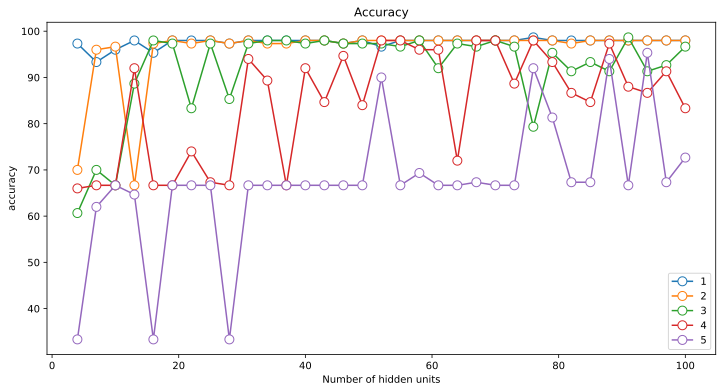

In [96]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,figsize=(12,6))

ax.plot(numunits,accuracies,'o-',markerfacecolor='w',markersize=9)
# ax.plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
# ax.plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(numlayers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

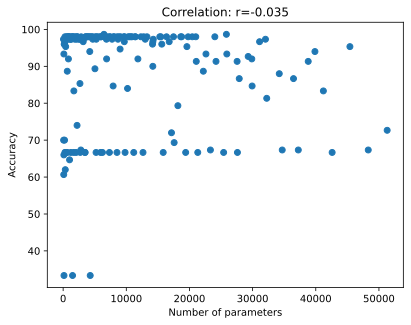

In [97]:
# Maybe it's simply a matter of more parameters -> better performance?

# vectorize for convenience
x = totalparams.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x,y)[0,1]

# scatter plot
plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r,3)))
plt.show()

**FINAL LEARNINGS:**

1. Deeper models are not always better. Yes, they always require more training and more FLOPs.
2. Model performance is not simply a function of the number of trainable parameters. Architecture Matters.
3. Shallow models learn fast, but deeper models can learn more complex mappings. (Covered in later sections)